## Replicating the IOI paper

In [56]:
__author__ = "Aryaman Arora"
__version__ = "1/24/2023"

### Overview

We're going to try to replicate some results of the original IOI paper ([Wang et al., 2022](https://arxiv.org/abs/2211.00593)) using `pyvene`, as a demonstration of path patching and verification of their results.

### Setup

In [57]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import pyvene

except ModuleNotFoundError:
    !pip install git+https://github.com/frankaging/pyvene.git

In [58]:
import random
import pandas as pd
from tutorial_ioi_utils import *
import pyvene as pv

import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    scale_y_reverse,
    scale_fill_cmap,
    geom_text,
    theme_bw,
    xlim,
    ylim,
    scale_x_continuous
)

# please try not to do this, the plot somehow throw warnings though :(
import warnings

warnings.filterwarnings("ignore")

config, tokenizer, gpt2 = pv.create_gpt2_lm(cache_dir="/Users/aryamanarora/.cache/huggingface/hub/")
_ = gpt2.eval()

titles={
    "block_output": "single restored layer in GPT2-XL",
    "mlp_activation": "center of interval of 10 patched mlp layer",
    "attention_output": "center of interval of 10 patched attn layer"
}

colors={
    "block_output": "Purples",
    "mlp_activation": "Greens",
    "attention_output": "Reds"
} 

KeyboardInterrupt: 

### Path patching config

This is taken from the `pyvene` 101 tutorial. Basically, we'll intervene at all positions for a single attention head, and restore the base input for all upstream model components. This will get the direct effect of the intervention on the logits.

In [ ]:
def path_patching_config(
    layer, last_layer, 
    component="head_attention_value_output", unit="h.pos"
):
    intervening_component = [
        {"layer": layer, "component": component, "unit": unit, "group_key": 0}]
    restoring_components = []
    if not component.startswith("mlp_"):
        restoring_components += [
            {"layer": layer, "component": "mlp_output", "group_key": 1}]
    for i in range(layer+1, last_layer):
        restoring_components += [
            {"layer": i, "component": "attention_output", "group_key": 1},
            {"layer": i, "component": "mlp_output", "group_key": 1}
        ]
    intervenable_config = pv.IntervenableConfig(
        intervening_component + restoring_components)
    return intervenable_config, len(restoring_components)

### Dataset + Utils

Just sampling prompts for the IOI task.

In [ ]:
test_distribution = PromptDistribution(
    names=NAMES,
    objects=OBJECTS,
    places=PLACES,
    templates=TEMPLATES,
)

D_test = test_distribution.sample_das(
    tokenizer=tokenizer,
    base_patterns=[
        "ABB",
    ],
    source_patterns=["DCE"],
    labels="name",
    samples_per_combination=25,
) + test_distribution.sample_das(
    tokenizer=tokenizer,
    base_patterns=[
        "BAB",
    ],
    source_patterns=["DCE"],
    labels="name",
    samples_per_combination=25,
)

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

def get_last_token(logits, attention_mask):
    last_token_indices = attention_mask.sum(1) - 1
    batch_indices = torch.arange(logits.size(0)).unsqueeze(1)
    return logits[batch_indices, last_token_indices.unsqueeze(1)].squeeze(1)

In [ ]:
for batch in D_test.batches(batch_size=1):
    print(batch.base, batch.base.tokens['input_ids'].shape, tokenizer.decode(batch.patched_answer_tokens[0][1]))
    print(batch.source, batch.source.tokens['input_ids'].shape, tokenizer.decode(batch.patched_answer_tokens[0][0]))
    break

[<===PROMPT=== Then, Justin and Bryan went to the hospital. Justin gave a necklace to>] torch.Size([1, 15])  Bryan
[<===PROMPT=== Then, Courtney and Thomas went to the hospital. Ashley gave a necklace to>] torch.Size([1, 15])  None


We're also implementing the logit diff metric, which checks the difference in logits between the two names in the sentence. Positive logit diff means a correct prediction is more likely (the IO, i.e. non-subject name).

In [ ]:
def compute_logit_diff(logits: torch.tensor, batch):
    base_logit = get_last_token(logits, batch.base.tokens['attention_mask'])
    base_label = batch.patched_answer_tokens[:, 1].to(gpt2.device)
    logit_diffs = []
    for batch_i in range(base_logit.size(0)):
        correct_name = base_label[batch_i]
        other_name = tokenizer.encode(' ' + batch.base.prompts[batch_i].s_name)[0]
        logit_diffs.append(base_logit[batch_i, correct_name] - base_logit[batch_i, other_name])
    return logit_diffs

They reported a baseline logit difference of 3.56 and a task accuracy of 99.3% for GPT-2 in the paper. Let's check if this holds on our dataset (it pretty much does):

In [61]:
with torch.no_grad():
    logit_diffs = []
    argmax_acc = 0
    for batch in tqdm(D_test.batches(batch_size=5), total=10):
        base_label = batch.patched_answer_tokens[:, 1].to(gpt2.device)
        base_logit = get_last_token(gpt2(**batch.base.tokens).logits, batch.base.tokens['attention_mask'])
        src_logit = get_last_token(gpt2(**batch.source.tokens).logits, batch.source.tokens['attention_mask'])
        for batch_i in range(5):
            other_name = tokenizer.encode(' ' + batch.base.prompts[batch_i].s_name)[0]
            correct_name = base_label[batch_i]

            # logit diff
            logit_diffs.append(
                base_logit[batch_i, base_label[batch_i]] - base_logit[batch_i, other_name].item())

            # baseline accuracy
            argmax = base_logit[batch_i].argmax()
            if argmax == base_label[batch_i]:
                argmax_acc += 1

    logit_diff = (sum(logit_diffs) / len(logit_diffs)).item()
    print("avg logit diff:", logit_diff)
    print("argmax acc:", argmax_acc / 50)

100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

avg logit diff: 3.7562549114227295
argmax acc: 0.94


### Name mover heads

We will replicate figure 3, which identifies heads which directly affect the logits.

In [64]:
data = []

with torch.no_grad():
    for layer in range(8, 12):
        intervenable_config, num_restores = path_patching_config(layer, 12)
        intervenable = IntervenableModel(intervenable_config, gpt2, use_fast=True)

        for head in range(gpt2.config.n_head):
            eval_labels, eval_preds, logit_diffs = [], [], []
            for batch_dataset in tqdm(D_test.batches(batch_size=1), total=50):
                # prepare
                base_inputs = batch_dataset.base.tokens
                source_inputs = batch_dataset.source.tokens
                labels = batch_dataset.patched_answer_tokens[:, 1].to(gpt2.device)
                pos = list(range(base_inputs["input_ids"].shape[-1]))

                # inference
                _, counterfactual_outputs = intervenable(
                    {"input_ids": base_inputs["input_ids"]}, 
                    [{"input_ids": source_inputs["input_ids"]}, {"input_ids": base_inputs["input_ids"]}],
                    {"sources->base": ((
                        [[[[head]], [pos]]]+[[pos]]*num_restores, 
                        [[[[head]], [pos]]]+[[pos]]*num_restores
                    ))}
                )
                logit_diffs.extend(compute_logit_diff(counterfactual_outputs.logits, batch_dataset))
                eval_labels += [labels]
                last_token_logits = get_last_token(counterfactual_outputs.logits, batch_dataset.base.tokens['attention_mask']).unsqueeze(1)
                eval_preds += [last_token_logits]
            
            # metrics
            eval_metrics = compute_metrics(
                eval_preds, eval_labels,
            )
            mean_logit_diff = sum(logit_diffs) / len(logit_diffs)
            data.append({"layer": layer, "head": head, "logit_diff": mean_logit_diff, **eval_metrics})
            print(data[-1])



In case multiple location tags are passed only the first one will be considered
100%|██████████| 50/50 [00:07<00:00,  6.68it/s]


{'layer': 8, 'head': 0, 'logit_diff': tensor(3.7504), 'accuracy': 0.94, 'kl_div': tensor(-74.3469), 'label_logit': -74.34694038391113, 'label_prob': 0.5380359962582588}


100%|██████████| 50/50 [00:06<00:00,  7.44it/s]


{'layer': 8, 'head': 1, 'logit_diff': tensor(3.7568), 'accuracy': 0.94, 'kl_div': tensor(-74.4057), 'label_logit': -74.40572700500488, 'label_prob': 0.5395114549994469}


100%|██████████| 50/50 [00:06<00:00,  7.22it/s]


{'layer': 8, 'head': 2, 'logit_diff': tensor(3.8010), 'accuracy': 0.94, 'kl_div': tensor(-74.4281), 'label_logit': -74.42814888000488, 'label_prob': 0.5384641465544701}


100%|██████████| 50/50 [00:06<00:00,  7.38it/s]


{'layer': 8, 'head': 3, 'logit_diff': tensor(3.7179), 'accuracy': 0.92, 'kl_div': tensor(-74.5966), 'label_logit': -74.59663963317871, 'label_prob': 0.5215314196050167}


100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


{'layer': 8, 'head': 4, 'logit_diff': tensor(3.7548), 'accuracy': 0.94, 'kl_div': tensor(-74.4089), 'label_logit': -74.40891792297363, 'label_prob': 0.5398365586996079}


100%|██████████| 50/50 [00:07<00:00,  6.36it/s]


{'layer': 8, 'head': 5, 'logit_diff': tensor(3.7737), 'accuracy': 0.94, 'kl_div': tensor(-74.4948), 'label_logit': -74.49480590820312, 'label_prob': 0.5443936404585838}


100%|██████████| 50/50 [00:08<00:00,  6.24it/s]


{'layer': 8, 'head': 6, 'logit_diff': tensor(3.8182), 'accuracy': 0.94, 'kl_div': tensor(-74.4737), 'label_logit': -74.47373725891113, 'label_prob': 0.5551303905248642}


100%|██████████| 50/50 [00:06<00:00,  7.79it/s]


{'layer': 8, 'head': 7, 'logit_diff': tensor(3.7553), 'accuracy': 0.94, 'kl_div': tensor(-74.4145), 'label_logit': -74.41451263427734, 'label_prob': 0.5396078166365623}


100%|██████████| 50/50 [00:07<00:00,  7.13it/s]


{'layer': 8, 'head': 8, 'logit_diff': tensor(3.7844), 'accuracy': 0.94, 'kl_div': tensor(-74.4013), 'label_logit': -74.40127014160156, 'label_prob': 0.536662351489067}


100%|██████████| 50/50 [00:07<00:00,  7.08it/s]


{'layer': 8, 'head': 9, 'logit_diff': tensor(3.7546), 'accuracy': 0.94, 'kl_div': tensor(-74.4106), 'label_logit': -74.41055702209472, 'label_prob': 0.5401303231716156}


100%|██████████| 50/50 [00:07<00:00,  6.89it/s]


{'layer': 8, 'head': 10, 'logit_diff': tensor(3.5075), 'accuracy': 0.94, 'kl_div': tensor(-74.2388), 'label_logit': -74.23884353637695, 'label_prob': 0.5428883665800095}


100%|██████████| 50/50 [00:06<00:00,  7.37it/s]

In case multiple location tags are passed only the first one will be considered


{'layer': 8, 'head': 11, 'logit_diff': tensor(3.7405), 'accuracy': 0.92, 'kl_div': tensor(-74.6022), 'label_logit': -74.60216705322266, 'label_prob': 0.5177586142718792}


100%|██████████| 50/50 [00:06<00:00,  7.30it/s]


{'layer': 9, 'head': 0, 'logit_diff': tensor(3.7050), 'accuracy': 0.94, 'kl_div': tensor(-74.6208), 'label_logit': -74.620824508667, 'label_prob': 0.5102730639278888}


100%|██████████| 50/50 [00:06<00:00,  7.15it/s]


{'layer': 9, 'head': 1, 'logit_diff': tensor(3.7559), 'accuracy': 0.94, 'kl_div': tensor(-74.4151), 'label_logit': -74.41508010864258, 'label_prob': 0.5392078700661659}


100%|██████████| 50/50 [00:06<00:00,  7.28it/s]


{'layer': 9, 'head': 2, 'logit_diff': tensor(3.7019), 'accuracy': 0.94, 'kl_div': tensor(-74.6157), 'label_logit': -74.61571449279785, 'label_prob': 0.5136157578229904}


100%|██████████| 50/50 [00:08<00:00,  6.16it/s]


{'layer': 9, 'head': 3, 'logit_diff': tensor(3.7431), 'accuracy': 0.94, 'kl_div': tensor(-74.3672), 'label_logit': -74.3671482849121, 'label_prob': 0.5368358224630356}


100%|██████████| 50/50 [00:07<00:00,  6.46it/s]


{'layer': 9, 'head': 4, 'logit_diff': tensor(3.7632), 'accuracy': 0.94, 'kl_div': tensor(-74.4501), 'label_logit': -74.45014938354493, 'label_prob': 0.5293045191466809}


100%|██████████| 50/50 [00:07<00:00,  6.86it/s]


{'layer': 9, 'head': 5, 'logit_diff': tensor(3.7335), 'accuracy': 0.94, 'kl_div': tensor(-74.4766), 'label_logit': -74.47663719177245, 'label_prob': 0.5465028408169746}


100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


{'layer': 9, 'head': 6, 'logit_diff': tensor(2.7914), 'accuracy': 0.7, 'kl_div': tensor(-76.0374), 'label_logit': -76.03742889404298, 'label_prob': 0.29187622375786304}


100%|██████████| 50/50 [00:07<00:00,  7.05it/s]


{'layer': 9, 'head': 7, 'logit_diff': tensor(3.7026), 'accuracy': 0.94, 'kl_div': tensor(-74.3311), 'label_logit': -74.33110733032227, 'label_prob': 0.5488018499314785}


100%|██████████| 50/50 [00:07<00:00,  7.05it/s]


{'layer': 9, 'head': 8, 'logit_diff': tensor(3.7859), 'accuracy': 0.94, 'kl_div': tensor(-74.8128), 'label_logit': -74.81278228759766, 'label_prob': 0.4744531024992466}


100%|██████████| 50/50 [00:07<00:00,  6.61it/s]


{'layer': 9, 'head': 9, 'logit_diff': tensor(1.4911), 'accuracy': 0.22, 'kl_div': tensor(-77.3908), 'label_logit': -77.39078643798828, 'label_prob': 0.12255394758656621}


100%|██████████| 50/50 [00:07<00:00,  6.70it/s]


{'layer': 9, 'head': 10, 'logit_diff': tensor(3.7551), 'accuracy': 0.94, 'kl_div': tensor(-74.3962), 'label_logit': -74.39617370605468, 'label_prob': 0.5393955698609352}


100%|██████████| 50/50 [00:07<00:00,  6.31it/s]

In case multiple location tags are passed only the first one will be considered


{'layer': 9, 'head': 11, 'logit_diff': tensor(3.7567), 'accuracy': 0.94, 'kl_div': tensor(-74.4002), 'label_logit': -74.40017051696778, 'label_prob': 0.5373660787940026}


100%|██████████| 50/50 [00:07<00:00,  6.85it/s]


{'layer': 10, 'head': 0, 'logit_diff': tensor(3.1255), 'accuracy': 0.66, 'kl_div': tensor(-75.9131), 'label_logit': -75.91307647705078, 'label_prob': 0.3100175105780363}


100%|██████████| 50/50 [00:06<00:00,  7.76it/s]


{'layer': 10, 'head': 1, 'logit_diff': tensor(3.6291), 'accuracy': 0.92, 'kl_div': tensor(-74.7467), 'label_logit': -74.74669570922852, 'label_prob': 0.4808885481953621}


100%|██████████| 50/50 [00:06<00:00,  7.71it/s]


{'layer': 10, 'head': 2, 'logit_diff': tensor(3.6425), 'accuracy': 0.88, 'kl_div': tensor(-74.8445), 'label_logit': -74.84453872680665, 'label_prob': 0.4534783412516117}


100%|██████████| 50/50 [00:06<00:00,  7.57it/s]


{'layer': 10, 'head': 3, 'logit_diff': tensor(3.7048), 'accuracy': 0.92, 'kl_div': tensor(-74.5217), 'label_logit': -74.52171600341796, 'label_prob': 0.5153644406795501}


100%|██████████| 50/50 [00:06<00:00,  7.59it/s]


{'layer': 10, 'head': 4, 'logit_diff': tensor(3.7698), 'accuracy': 0.94, 'kl_div': tensor(-74.6806), 'label_logit': -74.68061622619629, 'label_prob': 0.5424765661358834}


100%|██████████| 50/50 [00:06<00:00,  7.19it/s]


{'layer': 10, 'head': 5, 'logit_diff': tensor(3.7580), 'accuracy': 0.94, 'kl_div': tensor(-74.3888), 'label_logit': -74.3887621307373, 'label_prob': 0.5407887950539589}


100%|██████████| 50/50 [00:07<00:00,  7.00it/s]


{'layer': 10, 'head': 6, 'logit_diff': tensor(3.4450), 'accuracy': 0.9, 'kl_div': tensor(-75.0385), 'label_logit': -75.0384928894043, 'label_prob': 0.4376738278567791}


100%|██████████| 50/50 [00:07<00:00,  6.58it/s]


{'layer': 10, 'head': 7, 'logit_diff': tensor(5.1090), 'accuracy': 0.98, 'kl_div': tensor(-72.2116), 'label_logit': -72.21165046691894, 'label_prob': 0.8099988362193108}


100%|██████████| 50/50 [00:07<00:00,  6.89it/s]


{'layer': 10, 'head': 8, 'logit_diff': tensor(3.7607), 'accuracy': 0.94, 'kl_div': tensor(-74.4309), 'label_logit': -74.43088127136231, 'label_prob': 0.5412813138961792}


100%|██████████| 50/50 [00:06<00:00,  7.34it/s]


{'layer': 10, 'head': 9, 'logit_diff': tensor(3.7759), 'accuracy': 0.92, 'kl_div': tensor(-74.4457), 'label_logit': -74.44571556091309, 'label_prob': 0.5376637886464596}


100%|██████████| 50/50 [00:06<00:00,  7.46it/s]


{'layer': 10, 'head': 10, 'logit_diff': tensor(3.1971), 'accuracy': 0.8, 'kl_div': tensor(-75.1706), 'label_logit': -75.17062294006348, 'label_prob': 0.38778901934623716}


100%|██████████| 50/50 [00:06<00:00,  7.67it/s]

In case multiple location tags are passed only the first one will be considered


{'layer': 10, 'head': 11, 'logit_diff': tensor(3.7515), 'accuracy': 0.94, 'kl_div': tensor(-74.4513), 'label_logit': -74.4512720489502, 'label_prob': 0.5345661920309067}


100%|██████████| 50/50 [00:06<00:00,  7.49it/s]


{'layer': 11, 'head': 0, 'logit_diff': tensor(3.7527), 'accuracy': 0.94, 'kl_div': tensor(-74.4928), 'label_logit': -74.49275856018066, 'label_prob': 0.5453835587203503}


100%|██████████| 50/50 [00:06<00:00,  7.53it/s]


{'layer': 11, 'head': 1, 'logit_diff': tensor(3.6884), 'accuracy': 0.9, 'kl_div': tensor(-74.3526), 'label_logit': -74.35264060974121, 'label_prob': 0.5213113659620285}


100%|██████████| 50/50 [00:06<00:00,  7.46it/s]


{'layer': 11, 'head': 2, 'logit_diff': tensor(4.2981), 'accuracy': 0.88, 'kl_div': tensor(-74.8699), 'label_logit': -74.86986404418946, 'label_prob': 0.4666699156165123}


100%|██████████| 50/50 [00:06<00:00,  7.71it/s]


{'layer': 11, 'head': 3, 'logit_diff': tensor(3.7677), 'accuracy': 0.9, 'kl_div': tensor(-74.9174), 'label_logit': -74.91741744995117, 'label_prob': 0.47216988608241084}


100%|██████████| 50/50 [00:06<00:00,  7.60it/s]


{'layer': 11, 'head': 4, 'logit_diff': tensor(3.7532), 'accuracy': 0.94, 'kl_div': tensor(-74.3741), 'label_logit': -74.37413780212403, 'label_prob': 0.5394928365945816}


100%|██████████| 50/50 [00:06<00:00,  7.54it/s]


{'layer': 11, 'head': 5, 'logit_diff': tensor(3.7504), 'accuracy': 0.94, 'kl_div': tensor(-74.3879), 'label_logit': -74.38786392211914, 'label_prob': 0.5406103874742985}


100%|██████████| 50/50 [00:07<00:00,  6.85it/s]


{'layer': 11, 'head': 6, 'logit_diff': tensor(3.7768), 'accuracy': 0.94, 'kl_div': tensor(-74.6573), 'label_logit': -74.65733688354493, 'label_prob': 0.4942662340402603}


100%|██████████| 50/50 [00:07<00:00,  6.83it/s]


{'layer': 11, 'head': 7, 'logit_diff': tensor(3.7518), 'accuracy': 0.94, 'kl_div': tensor(-74.4400), 'label_logit': -74.44003486633301, 'label_prob': 0.5410507157444954}


100%|██████████| 50/50 [00:07<00:00,  6.28it/s]


{'layer': 11, 'head': 8, 'logit_diff': tensor(3.7459), 'accuracy': 0.94, 'kl_div': tensor(-74.9492), 'label_logit': -74.94922843933105, 'label_prob': 0.535863026380539}


100%|██████████| 50/50 [00:08<00:00,  6.13it/s]


{'layer': 11, 'head': 9, 'logit_diff': tensor(3.6901), 'accuracy': 0.94, 'kl_div': tensor(-74.6614), 'label_logit': -74.66142028808594, 'label_prob': 0.4914996309578419}


100%|██████████| 50/50 [00:07<00:00,  6.31it/s]


{'layer': 11, 'head': 10, 'logit_diff': tensor(4.5615), 'accuracy': 0.96, 'kl_div': tensor(-72.9968), 'label_logit': -72.99680526733398, 'label_prob': 0.7122889611124993}


100%|██████████| 50/50 [00:07<00:00,  6.59it/s]

{'layer': 11, 'head': 11, 'logit_diff': tensor(3.7668), 'accuracy': 0.94, 'kl_div': tensor(-76.5733), 'label_logit': -76.57328651428223, 'label_prob': 0.507421883046627}


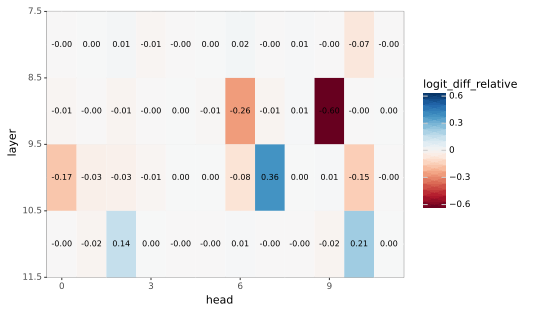

In [76]:
df = pd.DataFrame(data)
df["logit_diff"] = df["logit_diff"].apply(lambda x: x.item())
df["logit_diff_relative"] = (df["logit_diff"] - logit_diff) / logit_diff
lim = df["logit_diff_relative"].abs().max()
df["formatted"] = df["logit_diff_relative"].apply(lambda x: f"{x:.2f}")
plot = (
    ggplot(df, aes(x="head", y="layer", fill="logit_diff_relative")) + geom_tile()
    + scale_fill_cmap("RdBu", limits=(-lim, lim)) + scale_y_reverse(expand=[0, 0])
    + geom_text(aes(label="formatted"), size=8, color="black")
    + theme_bw() + scale_x_continuous(expand=[0, 0])
)
print(plot)